# CS4320 - Introduction to Machine Learning

## Homework 4: Logistic regression, hyperparameter optimization 

Please type your name and A number here:

In [1]:
Name = "Riley May"
assert Name != "", 'Please enter your name in the above quotation marks, thanks!'

A_number = "A02242497"
assert A_number != "", 'Please enter your A-number in the above quotation marks, thanks!'

## Imports 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split


## Exercise 1: implementing `DummyClassifier`
<hr>
rubric={points:25}

You will implement the simplest possible classifier, `DummyClassifier`.

As a reminder, `DummyClassifier` is meant as a baseline and is generally the worst possible "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more label(0) than label(1) it predicts label(0) every time, and if there are more label(1) than label(0) it predicts label(1) every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% label(0) 70% label(1) it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get you started, I have given you a `return` statement in each case that returns the correct data type: `fit` can return nothing, `predict` returns an array whose size is the number of examples, `predict_proba` returns an array whose size is the number of examples x 2, and `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of [`DummyClassifier(strategy='prior')`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html?highlight=dummyclassifier+strategy+prior). Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

In [3]:
class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.

    This implementation only works when y only contains 0s and 1s.
    """
    def __init__(self):
        '''Insert your code here'''
        self.__guess = None # predict None by default 
        self.__probabilities = [None, None]


    def fit(self, X, y):
        '''Insert your code here'''
        target = 0
        for val in y:
            if val == 1:
                target += 1
        if target / len(y) > .5:
            self.__guess = 1
        else:
            self.__guess = 0
            
        self.__probabilities = [1- target/ len(y), target /len(y)]
        return None 

    def predict(self, X):
        if self.__guess == 0:
            return np.zeros(X.shape[0])
        else:
            return np.ones(X.shape[0])
#         return np.zeros(X.shape[0])  # Replace with your code      

    def predict_proba(self, X):
        '''Insert your code here'''
        predict_array = np.zeros((X.shape[0], 2))
        for i in range(len(predict_array)):
            predict_array[i] = self.__probabilities 
        return predict_array

    def score(self, X, y):
        prediction = self.predict(X)
        right = 0
        for i in range(len(y)):
            if prediction[i] == y[i]:
                right +=1
            
        return right / len(y)  

Below are some tests for `predict` using randomly generated data. You may want to run the cell a few times to make sure you explore the different cases (or automate this with a loop or random seeds).

In [4]:
# For testing, generate random data
n_train = 101
n_valid = 21
d = 5
X_train_dummy = np.random.randn(n_train, d)
X_valid_dummy = np.random.randn(n_valid, d)
y_train_dummy = np.random.randint(2, size=n_train)
y_valid_dummy = np.random.randint(2, size=n_valid)

my_dc = MyDummyClassifier()
sk_dc = DummyClassifier(strategy="prior")

my_dc.fit(X_train_dummy, y_train_dummy)
sk_dc.fit(X_train_dummy, y_train_dummy)

assert np.array_equal(my_dc.predict(X_train_dummy), sk_dc.predict(X_train_dummy))
assert np.array_equal(my_dc.predict(X_valid_dummy), sk_dc.predict(X_valid_dummy))

Below are some tests for `predict_proba`.

In [5]:
assert np.allclose(
    my_dc.predict_proba(X_train_dummy), sk_dc.predict_proba(X_train_dummy)
)
assert np.allclose(
    my_dc.predict_proba(X_valid_dummy), sk_dc.predict_proba(X_valid_dummy)
)

Below are some tests for `score`.

In [6]:
assert np.isclose(
    my_dc.score(X_train_dummy, y_train_dummy), sk_dc.score(X_train_dummy, y_train_dummy)
)
assert np.isclose(
    my_dc.score(X_valid_dummy, y_valid_dummy), sk_dc.score(X_valid_dummy, y_valid_dummy)
)

## Exercise 2: Trump Tweets
<hr>
rubric={points:35}

For the rest of this assignment we'll be looking at a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. Unzip it and move the file `realdonaldtrump.csv` into this directory. As usual, please do not submit the dataset when you submit the assignment. 

In [7]:
tweets_df = pd.read_csv("realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [8]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [9]:
y = tweets_df["retweets"] > 10_000 

To make predictions, we'll be using only the content (text) of the tweet. 

In [10]:
X = tweets_df["content"]

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

#### 2(a) ordering the steps
rubric={points:8}

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

- Rearrange the lines of code to correctly fit the model and compute the cross-validation score. {points: 4} 
- Add a short comment to each block to describe what the code is doing. {points: 4}

In [11]:
'''Rearrange the code above and add your comment for each line'''

# SPLIT THE DATA FIRST.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=321)

# Initiatilze the vectorizer w
countvec = CountVectorizer(stop_words="english")

# Next we will make the regressor
lr = LogisticRegression(max_iter=1000)
 
# Make pipeline after making regression and the vector
pipe = make_pipeline(countvec, lr)

#After we made thsoe elements you can combine it into a single pipeline. 
cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)


# mean of results
cross_val_results.mean

<bound method NDFrame._add_numeric_operations.<locals>.mean of    fit_time  score_time  test_score  train_score
0  2.252012    0.244063    0.899123     0.966014
1  2.340352    0.234622    0.899739     0.968859
2  2.171479    0.218514    0.896356     0.965976
3  2.199005    0.233582    0.898201     0.968552
4  2.216833    0.234533    0.896032     0.965823>

Expected Output. (Note that we round to three decimal places. Your output could have more decimal places. )
- test_score     0.897
- train_score    0.967

#### 2(b) Cross-validation fold sub-scores
rubric={points:3}

Above we averaged the scores from the 5 folds of cross-validation. 

- Print out the 5 individual scores. Reminder: `sklearn` calls them `"test_score"` but they are really (cross-)validation scores. {points:1} 
- Are the 5 scores close to each other or spread far apart? (This is a bit subjective, answer to the best of your ability.) {points:1}
- How does the size of this dataset (number of rows) compare to the cities dataset we have been using in class? How does this relate to the different sub-scores from the 5 folds? {points:1}

In [12]:
'''Insert your code here'''
print(cross_val_results.test_score)

0    0.899123
1    0.899739
2    0.896356
3    0.898201
4    0.896032
Name: test_score, dtype: float64


Type your answer:

The 5 scores are very very similar to each other.  

The size of the data set is similar 43352 tweets versus the 200 something cities. A larger dataset means the subscores will be better for the larger data set. 


#### 2(c) baseline
rubric={points:5}

By the way, are these scores any good? 

- Run `DummyClassifier` (or `MyDummyClassifier`!) on this dataset (You only do cross validation on the training data like (a)). {points:2}
    - Expected Output. Mean cross_val_results is
        - test_score     0.738
        - train_score    0.738
- Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful? {points:1}
- Is it necessary to use `CountVectorizer` here? Briefly explain. {points:2}

In [13]:
'''Insert your code here'''

my_dc = MyDummyClassifier()
sk_dc = DummyClassifier(strategy="prior")


# r1 = cross_validate(my_dc, X_train, y_train, return_train_score=True)
# r2 = pd.DataFrame(cross_validate(sk_dc, X_train, y_train, return_train_score=True))

cross_val_results1 = pd.DataFrame(
    cross_validate(sk_dc, X_train, y_train, return_train_score=True)
)

cross_val_results1.mean()

fit_time       0.004593
score_time     0.000996
test_score     0.738543
train_score    0.738543
dtype: float64

Type your answer:

Yes. Logisitic regression got a much better score than the dummy classifier.

No. It is isn't necessary to use Count Vectorizer. The Dummy Classifier only looks at Y values

#### 2(d) probability scores
rubric={points:5}

Here we train a logistic regression classifier on the entire training set: 

(Note: this is relying on the `pipe` variable from 2(a) - you'll need to redefine it if you overwrote that variable in between.)

In [14]:
pipe.fit(X_train, y_train) # train a logistic regression classifier on the entire training set

Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Print out the tweet and the associated probability score.

In [15]:
'''Insert your code here'''
viral = pipe.predict_proba(X_test)

tweet_index = 0
tweet_chance = 0

for t in range(len(viral)):
    if viral[t][1] > tweet_chance:
        tweet_index = t
        tweet_chance = viral[t][1]


print(X_test.iloc[tweet_index])
print(tweet_chance)

Corrupt politician Adam Schiff wants people from the White House to testify in his and Pelosi’s disgraceful Witch Hunt, yet he will not allow a White House lawyer, nor will he allow ANY of our requested witnesses. This is a first in due process and Congressional history!
0.9999999325256291


#### 2(e) coefficients
rubric={points:4}

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `make_pipeline` object as follows:

In [16]:
vec_from_pipe = pipe.named_steps["countvectorizer"]
lr_from_pipe = pipe.named_steps["logisticregression"]

Using these extracted components above, display the 5 words with the highest coefficients and the 5 words with the smallest coefficients.

In [17]:
'''Insert your code here'''
words = vec_from_pipe.get_feature_names()
most = np.argpartition(lr_from_pipe.coef_[0], -5)[-5:]
least = np.argpartition(lr_from_pipe.coef_[0], 5)[:5]

# print(most, least)
print("Highest words")
for i in most:
    print(words[i], end=" ")
    
print(" \n Lowest words")
for i in least:
    print(words[i], end=" ")

Highest words
transcripts coronavirus fake mini harassment  
 Lowest words
trump2016pic realdonaldtrump barackobama trump2016 1pic 

- The highest 5 words should be: harassment, mini, fake, coronavirus, transcripts.
- The lowest 5 words should be: 1pic, trump2016, barackobama, trump2016pic, realdonaldtrump

#### 2(f)
rubric={points:10}

scikit-learn provides a lot of useful tools like `make_pipeline` and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. Here, your task is to "manually" (without `Pipeline`) compute logistic regression's validation score(that is, train on 80% and validate on 20%) of the training data.

You should start with the following `CountVectorizer` and `LogisticRegression` objects. You only need to furtherly split `X_train` and `y_train` into 80% training set and 20% validation set. Use lr.score() to show your validation score of your model performing on validation set.(In order to grade, we set random_state=123)

In [18]:
countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000)  

In [19]:
'''Insert your code here'''


X_newTrain, X_test2, y_newTrain, y_test2 = train_test_split(X_train, y_train, test_size=0.20, random_state=123)


X_newTrain = countvec.fit_transform(X_newTrain)

lr.fit(X_newTrain, y_newTrain)

X_test2 = countvec.transform(X_test2)

lr.score(X_test2, y_test2)

0.8929724742426572

Expected output value: 0.893

Meta-comment:I think this type of question (and Exercise 1) is a useful middle ground. I do want you to know what is going on in `Pipeline` and in `cross_validate` even if we don't cover the details of `fit`. To get into logistic regression's `fit` requires a bunch of math; here, we're keeping it more conceptual and avoiding all those prerequisites.

## Exercise 3: hyperparameter optimization
<hr>
rubric={points:25}

#### 3(a)
rubric={points:4}

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. Based on the plot/output, what value of `max_features` seems best? Briefly explain.

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

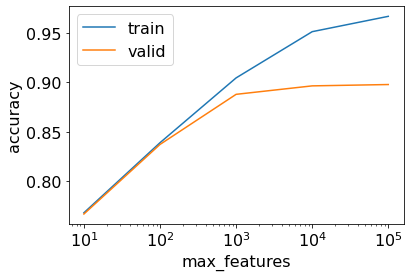

In [20]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    #     print(mf)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=mf),
        LogisticRegression(max_iter=1000),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy");

In [21]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.767854,0.766593
1,100,0.838900,0.837147
2,1000,0.904618,0.887956
3,10000,0.951498,0.896537
4,100000,0.967045,0.897890


Type your answer here:

I would believe that the best number of max_features  is 1000. The cross validation scores does not go up by much after that. It is simpler. 


#### 3(b)
rubric={points:4}

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. Based on the plot, what value of `C` seems best?

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

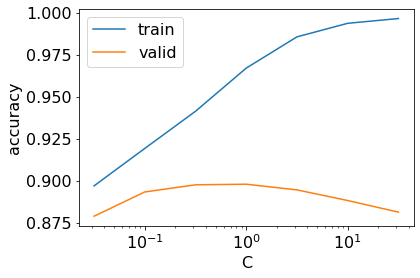

In [22]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-1.5, 2, 0.5)

for C in C_vals:
    # print(C)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=None),
        LogisticRegression(max_iter=1000, C=C),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [23]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.031623,0.896898,0.878821
1,0.100000,0.919196,0.893277
2,0.316228,0.941333,0.897521
3,1.000000,0.967045,0.897890
4,3.162278,0.985668,0.894507
5,10.000000,0.993733,0.888171
6,31.622777,0.996578,0.881251


Type your answer here:

I would say the a C value of 1 is the best possible one. That is where the cross validation score seems to peak. 

#### 3(c)
rubric={points:12}

- Using `GridSearchCV`, jointly optimize `max_features` and `C` across all the combinations of values we tried above.{points:8} 
  - Note: the code might be a bit slow here. 
  - Setting `n_jobs=-1` should speed it up if you have a multi-core processor.
  - You can reduce the number of folds (e.g. `cv=2`) to speed it up if necessary.
- What are the best values of `max_features` and `C` according to your grid search?(You can just print your best values){points:4}

In [24]:
'''Insert your code here'''
best_score = 0

param_grid = {
    "C": 10.0 ** np.arange(-1.5, 2, 0.5),
    "features": [10, 100, 1000, 10_000, 100_000],
}


results_dict = {"C": [], "features": [], "mean_cv_score": []}



for feature in param_grid["features"]:
    for C in param_grid["C"]:  # for each combination of parameters, train an SVC
        pipe = make_pipeline(
            CountVectorizer(stop_words="english", max_features=feature),
            LogisticRegression(max_iter=1000, C=C),)
        scores = cross_val_score(pipe, X_train, y_train, cv=2)  # perform cross-validation
        mean_score = np.mean(scores)  # compute mean cross-validation accuracy
        if (
            mean_score > best_score
        ):  # if we got a better score, store the score and parameters
            best_score = mean_score
            best_parameters = {"C": C, "features": feature}
        results_dict["C"].append(C)
        results_dict["features"].append(feature)
        results_dict["mean_cv_score"].append(mean_score)

In [25]:
new = pd.DataFrame.from_dict(results_dict)
# print(new)

print("The best score is :", best_score)


print("The parameters for the best score are C:  0.316228   Features:  100000" )

The best score is : 0.8928154025958048
The parameters for the best score are C:  0.316228   Features:  100000


Please print out your best values of max_feature and C. They should be 100000 and 0.316 respectively.

#### 3(d)
rubric={points:5}

- Evaluate your final model on the test set.{points:3} 
    - Expected test accuracy is 0.899
- How does your test accuracy compare to your validation accuracy?{points:2} 

In [26]:
'''Insert your code here'''
from sklearn.metrics import accuracy_score

pipe = make_pipeline(
            CountVectorizer(stop_words="english", max_features=100000),
            LogisticRegression(max_iter=1000, C=0.316228   ),)

pipe.fit(X_train, y_train)

predict = pipe.predict(X_test)

accuracy_score(predict, y_test)

0.8986897951651597

Type your answer here:

The results are very similar. The accuracy is nearly exactly the same as the validation accuracy.  

In [27]:
0.8986897951651597 - 0.8928154025958048

0.005874392569354847

## Exercise 4: Very short answer questions
rubric={points:15}

Each question is worth 3 points.

1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`? 
2. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?
3. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.
4. What are two advantages of using sklearn `Pipeline`s? 
5. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?

Type your answer here:

1.  As part of the golden rule, you shouldn't touch the test data. Fit transform alters the test data. 

2.  As you violate the Golden Rule, you will get improper results. If we violate the Golden Rule it will most likely  give you  a worse classifier and overfitting. 

3. predict_proba. You can get the chance of each being in a certain category. Then you can do the prediction yourself.

4.  It combines elements together  of preprocessing together into step. This helps prevent data leaks. The key benefit of building a pipeline is improved readability.

5. Randomized serach may improve the the search time as it may find the best results faster. Additionally, we can avoid testing all of the different combinations.  It is also better with more parameters. 

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`.
2. Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Please keep your notebook clean and delete any throwaway code.